In [1]:
import tensorflow as tf
from prepare_dataset import create_dataset_from_tfrecord

## Load Dataset

In [2]:
# create (image, label) dataset from generator
train_ds = create_dataset_from_tfrecord('dataset/qq_captcha_train.tfrecords', 
                                        batch_size=128, 
                                        image_size=(60, 120), 
                                        label_prefix='A',
                                        buffer_size=1000).cache()
test_ds = create_dataset_from_tfrecord('dataset/qq_captcha_test.tfrecords', 
                                       batch_size=128, 
                                       image_size=(60, 120), 
                                       label_prefix='A',
                                       buffer_size=1000).cache()

## Create Model

In [7]:
def CNN_multi_outputs(image_shape, n_labels=4, n_class=26, name='captcha', output_label='labels'):
    # input
    image_input = tf.keras.Input(shape=image_shape, name='input_image')

    # conv layer 1
    x = tf.keras.layers.Conv2D(16, (3, 3))(image_input)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)

    # conv layer 2
    x = tf.keras.layers.Conv2D(32, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # conv layer 3
    x = tf.keras.layers.Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    # conv layer 4
    x = tf.keras.layers.Conv2D(64, (3, 3))(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # dense layer
    x = tf.keras.layers.Flatten()(x) # flatten
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # outputs
    labels = [tf.keras.layers.Dense(n_class, name=f'{output_label}{i}')(x) for i in range(n_labels)] 

    # build model
    model = tf.keras.Model(inputs=image_input, outputs=labels, name=name)
    
    return model

In [8]:
image_shape = (60, 120, 1)
n_labels = 4
n_class = 26

model = CNN_multi_outputs(image_shape, n_labels, n_class, name='cnn_multi_outputs', output_label='A')
model.summary()

Model: "cnn_multi_outputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 58, 118, 16)  160         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 29, 59, 16)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 27, 57, 32)   4640        max_pooling2d_8[0][0]            
__________________________________________________________________________________

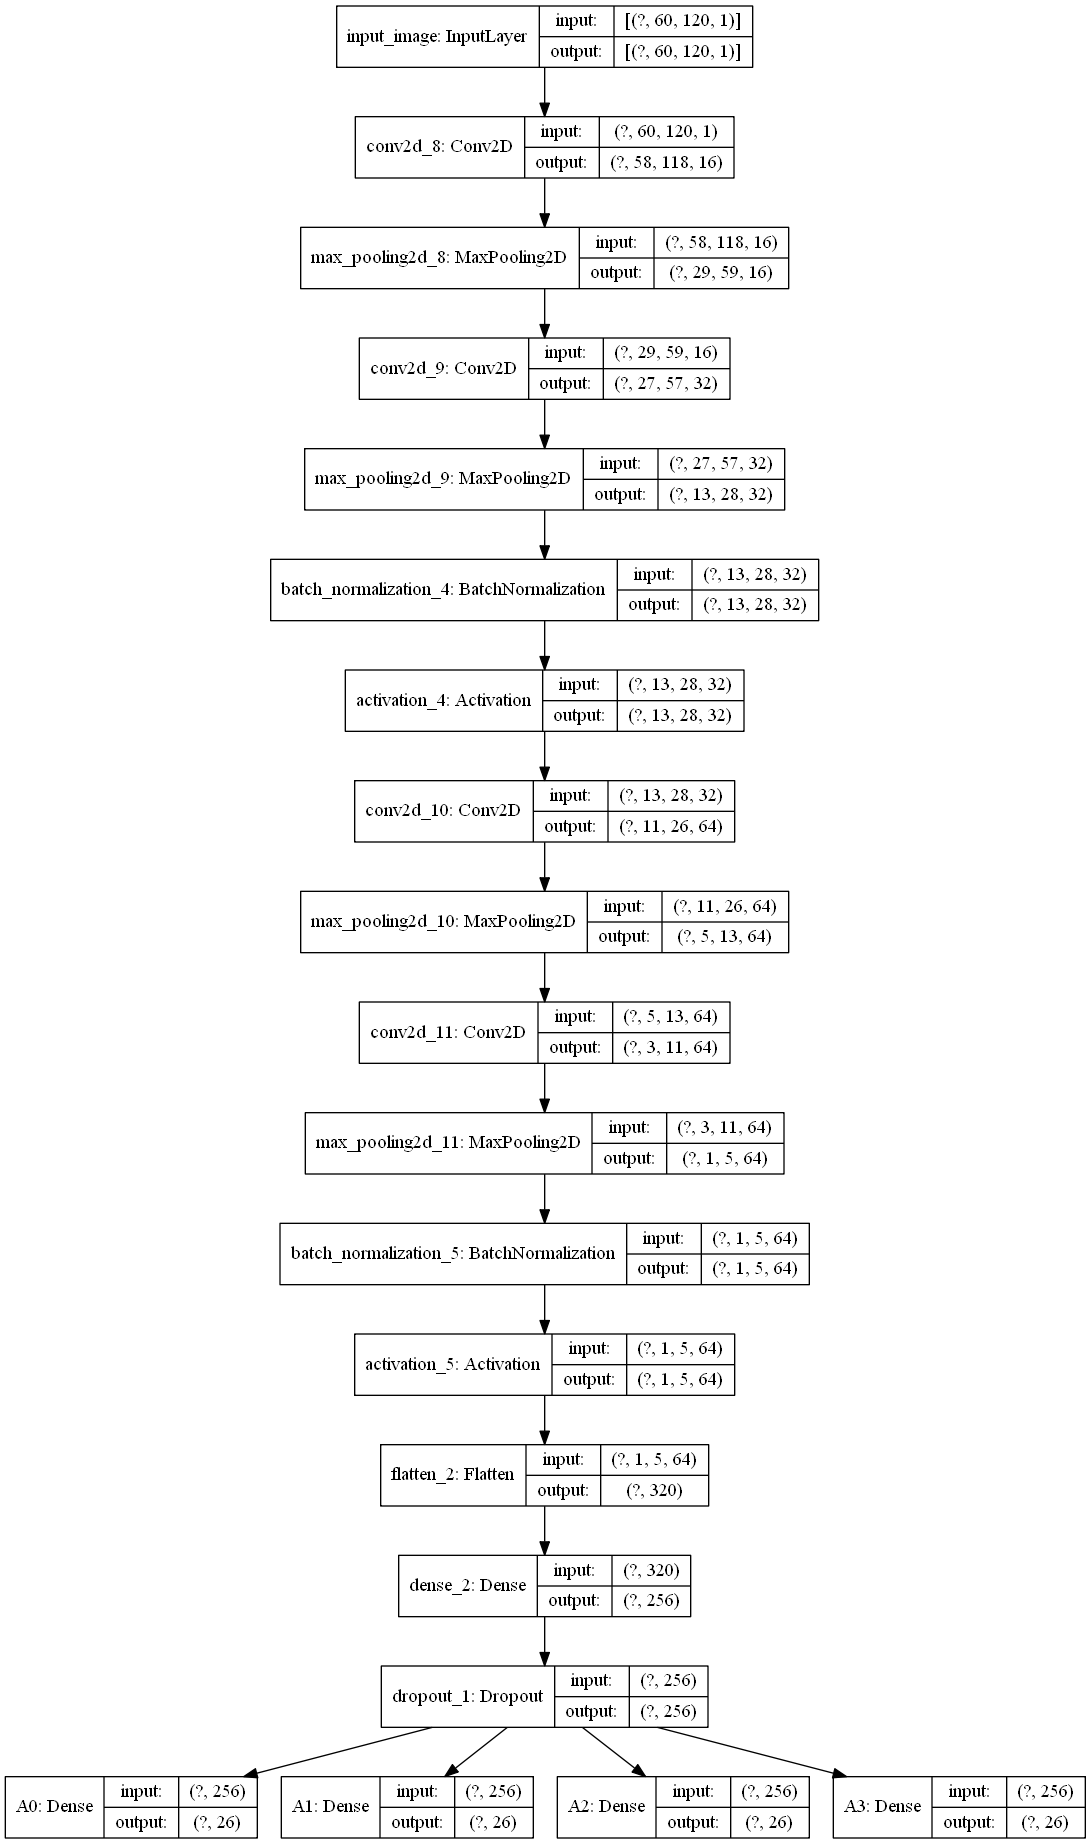

In [9]:
tf.keras.utils.plot_model(model, f'{model.name}.png', show_shapes=True)

## Train Model

In [10]:
# set loss for each output lables, or set a same loss for all labels
# e.g. loss={ f'labels_{i}': 
#   tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for i in range(n_labels)}
model.compile(optimizer="adam", #tf.keras.optimizers.RMSprop(0.001, 0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
import os

# load model if exists
model_dir = os.path.join('models', model.name) # saved in folder with same name
if os.path.exists(model_dir):
    model = tf.keras.models.load_model(model_dir)

model.fit(train_ds, 
          epochs=100, 
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tensorboard'))])

Epoch 1/100
708/708 [==============================] - 192s 271ms/step - loss: 11.5620 - A0_loss: 2.7999 - A1_loss: 2.8995 - A2_loss: 2.9432 - A3_loss: 2.9193 - A0_accuracy: 0.1643 - A1_accuracy: 0.1402 - A2_accuracy: 0.1272 - A3_accuracy: 0.1351
Epoch 2/100
708/708 [==============================] - 185s 262ms/step - loss: 7.9131 - A0_loss: 1.6552 - A1_loss: 2.0675 - A2_loss: 2.1721 - A3_loss: 2.0182 - A0_accuracy: 0.4942 - A1_accuracy: 0.3818 - A2_accuracy: 0.3545 - A3_accuracy: 0.4001
Epoch 3/100
708/708 [==============================] - 186s 262ms/step - loss: 6.1615 - A0_loss: 1.2261 - A1_loss: 1.6117 - A2_loss: 1.7193 - A3_loss: 1.6044 - A0_accuracy: 0.6262 - A1_accuracy: 0.5176 - A2_accuracy: 0.4891 - A3_accuracy: 0.5220
Epoch 4/100
708/708 [==============================] - 191s 269ms/step - loss: 5.3260 - A0_loss: 1.0399 - A1_loss: 1.3878 - A2_loss: 1.4933 - A3_loss: 1.4049 - A0_accuracy: 0.6857 - A1_accuracy: 0.5845 - A2_accuracy: 0.5553 - A3_accuracy: 0.5849
Epoch 5/100
708

In [9]:
# save the entire model
model.save(model_dir, save_format='tf')

INFO:tensorflow:Assets written to: models\cnn_multi_outputs\assets


## Test Model

In [10]:
# load model
new_model = tf.keras.models.load_model(model_dir)

In [11]:
# evaluate model: predict four labels correctly
import numpy as np

def evaluate_captcha(model, dataset):
    '''evaluate the model with test dataset:
       the prediction is good only when the four labels are predicted correctly.
    '''
    num = 0
    scores = [0] * 5 # total, label1-4
    for images, dict_labels in dataset.as_numpy_iterator():
        outputs = model.predict(images) # list
        for (image, *zip_labels) in zip(images, *dict_labels.values(), *outputs):
            num += 1
            labels = zip_labels[0:4] # true labels
            predict_labels = [np.argmax(label) for label in zip_labels[4:]]
            # get one score when the four predictions are correct
            flag = True
            for i, (a,b) in enumerate(zip(labels, predict_labels), start=1):
                if a==b:
                    scores[i] += 1
                else:
                    flag = False
            if flag:
                scores[0] += 1
    return [score / num if num else 0 for score in scores]

In [12]:
evaluate_captcha(new_model, test_ds)

[0.23710623074629833,
 0.779191096094604,
 0.6328132763589387,
 0.6184040544569214,
 0.7018781675444699]

predict labels: zazh
labels        : lafz


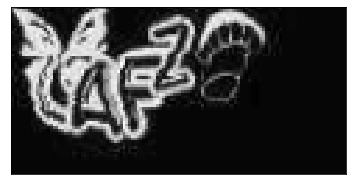

predict labels: gfph
labels        : efhh


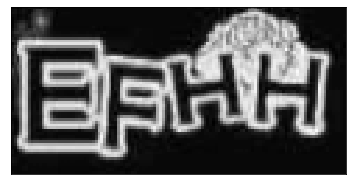

predict labels: rkty
labels        : rcty


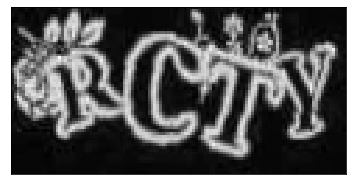

predict labels: fwet
labels        : fmet


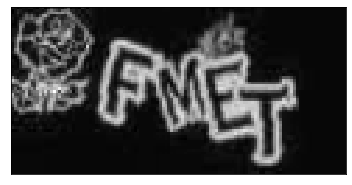

predict labels: cbad
labels        : cbad


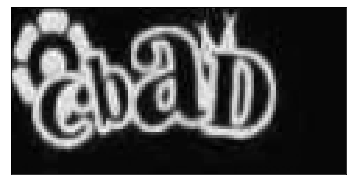

In [14]:
# prediction example
import matplotlib.pyplot as plt
%matplotlib inline

t = 50 # image t in batch

for x, y_ in test_ds.take(5):
   
    # predict labels
    y = new_model.predict(x)
    predict_labels = ''.join([chr(ord('a') + np.argmax(y[i][t])) for i in range(4)])
    print('predict labels:', predict_labels)
    
    # real labels
    labels = [y_[f'A{i}'][t].numpy()[0] for i in range(4)]
    labels = ''.join([chr(ord('a') + c) for c in labels])
    print('labels        :',labels)
    
    # show image
    image = tf.reshape(x.numpy()[t], shape=(60, 120))
    plt.imshow(image, cmap=plt.cm.binary)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()